Hacemos un análisis exploratorio básico, que en parte va a determinar una nueva limpieza del dataset.

  * Nos interesan sólo las variantes con un *effect size* asociado, que va a ser el peso de los enlaces en nuestra red. Quitamos las variantes sin esta información.
  * Algunas filas del dataframe contenían información de muchas variantes. Seleccionamos solamente filas que se refieren a **un único SNP o *indel***.

In [98]:
%run imports.py

data = pd.read_csv(results_dir + '/GwasCat_associations.r2020-05-03.parsed.csv.gz')

columnas_no_usadas = ["crom", "pos", "es_intergenico", "p_value", "frec_alelo_riesgo", "conf_int_95"]
data = data.drop(columnas_no_usadas, axis=1)
data = data.reset_index(drop=True)

data.head()

,categoria_fenotipo,fenotipo,genes_reportados,genes_mapeados,alelo_riesgo,contexto,OR_or_beta,EFO_URI
0,Digestive system disorder,Crohn's disease,IL2RA,IL2RA,rs12722489-C,intron_variant,1.11,http://www.ebi.ac.uk/efo/EFO_0000384
1,Digestive system disorder,Crohn's disease,"IL27, SH2B1, EIF3C, LAT, CD19","CLN3, AC138894.1",rs151181-G,intron_variant,1.07,http://www.ebi.ac.uk/efo/EFO_0000384
2,Digestive system disorder,Crohn's disease,IL23R,IL23R,rs11209026-G,missense_variant,2.66,http://www.ebi.ac.uk/efo/EFO_0000384
3,Digestive system disorder,Crohn's disease,"IL12RL2, IL18R1, IL1RL1, IL18RAP",IL18RAP,rs2058660-G,intron_variant,1.19,http://www.ebi.ac.uk/efo/EFO_0000384
4,Digestive system disorder,Crohn's disease,IL12B,AC008691.1,rs6556412-A,intron_variant,1.18,http://www.ebi.ac.uk/efo/EFO_0000384


In [99]:
print(f"{len(data):,} todas las asociaciones.")

mask_effect_size_present = ~data.OR_or_beta.isna()
data = data[mask_effect_size_present].reset_index(drop=True)

print(f"{len(data):,} sólo asociaciones con OR o beta.")

185,724 todas las asociaciones.
144,614 sólo asociaciones con OR o beta.


In [100]:
mask_multiple_variants = data.alelo_riesgo.str.contains(" x |;")
mask_asterisk_variant = data.alelo_riesgo.str.contains("\*")

data = data[(~mask_multiple_variants) & (~mask_asterisk_variant)].reset_index(drop=True)

print(f"{len(data):,} excluyendo asociaciones de muchas variantes y cosas raras.")

143,917 excluyendo asociaciones de muchas variantes y cosas raras.


Analizamos el "missingness" o distribución de valores faltantes en el resto de las columnas:

  * Una fracción baja de variantes no tiene gen reportado/mapeado.
  * Muy pocas no tienen categoría de general de fenotipo.
  * Los valores faltantes de contexto genómico no nos molestan. Es un dato extra, pero no esencial.
  * Los valores faltantes de frecuencia alélica tampoco nos molestan. Es un dato extra, pero no esencial.

In [101]:
data.isna().sum()

categoria_fenotipo      65
fenotipo                 0
genes_reportados      6631
genes_mapeados        5267
alelo_riesgo             0
contexto              5262
OR_or_beta               0
EFO_URI                 65
dtype: int64

Partimos de la idea de que cada fila describe una asociación variante-fenotipo única. Algunas entradas del dataset, sin embargo, repiten el mismo par (variante, fenotipo) con diferentes betas de asociación. Presumiblemente, son distintos fenotipos que no fueron cargados correctamente (comprobamos esto mirando a mano varios casos). Los descartamos:

In [102]:
print(f"{len(data):,} asociaciones antes de des-duplicar")

data = data.set_index(["fenotipo", "alelo_riesgo"])
indices_unicos = data.index.drop_duplicates(keep=False)
data = data.loc[indices_unicos].reset_index()

print(f"{len(data):,} asociaciones tras des-duplicar")

143,917 asociaciones antes de des-duplicar
112,626 asociaciones tras des-duplicar


Las columnas de genes reportados / mapeados son inconsistentes en su formato. Algunas reportan genes separados por coma, otras separan con un guión. "Intergenic" aparece con mayúscula y con minúscula, "NR" (no reportado) aparece como valor. Limpiamos todo esto.

In [103]:
def limpiar_genes(genes_str):
    no_es_gen = ["Intergenic", "intergenic", "NR"]
    if not pd.isnull(genes_str) and genes_str not in no_es_gen:
        return genes_str.replace(", ", " | ").replace(" - "," | ")
    
data["genes_mapeados"] = data.genes_mapeados.map(limpiar_genes)
data["genes_reportados"] = data.genes_reportados.map(limpiar_genes)

data

,fenotipo,alelo_riesgo,categoria_fenotipo,genes_reportados,genes_mapeados,contexto,OR_or_beta,EFO_URI
0,Crohn's disease,rs12722489-C,Digestive system disorder,IL2RA,IL2RA,intron_variant,1.1100,http://www.ebi.ac.uk/efo/EFO_0000384
1,Crohn's disease,rs151181-G,Digestive system disorder,IL27 | SH2B1 | EIF3C | LAT | CD19,CLN3 | AC138894.1,intron_variant,1.0700,http://www.ebi.ac.uk/efo/EFO_0000384
2,Crohn's disease,rs2058660-G,Digestive system disorder,IL12RL2 | IL18R1 | IL1RL1 | IL18RAP,IL18RAP,intron_variant,1.1900,http://www.ebi.ac.uk/efo/EFO_0000384
3,Crohn's disease,rs6556412-A,Digestive system disorder,IL12B,AC008691.1,intron_variant,1.1800,http://www.ebi.ac.uk/efo/EFO_0000384
4,Crohn's disease,rs2797685-A,Digestive system disorder,VAMP3,PER3 | Z98884.1,intron_variant,1.0500,http://www.ebi.ac.uk/efo/EFO_0000384
...,...,...,...,...,...,...,...,...
112621,Highest math class taken (MTAG),rs902627-A,Biological process,None,DPYSL4,intron_variant,0.0095,http://www.ebi.ac.uk/efo/EFO_0004875
112622,Lung adenocarcinoma,rs3117582-C,Cancer,APOM | BAT3,APOM,intron_variant,1.2200,http://www.ebi.ac.uk/efo/EFO_0000571
112623,Lung adenocarcinoma,rs1051730-T,Cancer,CHRNA5 | CHRNA3,CHRNA3,synonymous_variant,1.3100,http://www.ebi.ac.uk/efo/EFO_0000571
112624,Lung adenocarcinoma,rs31489-C,Cancer,CLPTM1L,CLPTM1L,intron_variant,1.1200,http://www.ebi.ac.uk/efo/EFO_0000571


Las categorías de "contexto genómico" todas dicen "variant" innecesariamente. Limpiamos.

In [104]:
def limpiar_contexto(context_str):
    if not pd.isnull(context_str):
        return context_str.replace("_variant", "")

data["contexto"] = data.contexto.map(limpiar_contexto)
data

,fenotipo,alelo_riesgo,categoria_fenotipo,genes_reportados,genes_mapeados,contexto,OR_or_beta,EFO_URI
0,Crohn's disease,rs12722489-C,Digestive system disorder,IL2RA,IL2RA,intron,1.1100,http://www.ebi.ac.uk/efo/EFO_0000384
1,Crohn's disease,rs151181-G,Digestive system disorder,IL27 | SH2B1 | EIF3C | LAT | CD19,CLN3 | AC138894.1,intron,1.0700,http://www.ebi.ac.uk/efo/EFO_0000384
2,Crohn's disease,rs2058660-G,Digestive system disorder,IL12RL2 | IL18R1 | IL1RL1 | IL18RAP,IL18RAP,intron,1.1900,http://www.ebi.ac.uk/efo/EFO_0000384
3,Crohn's disease,rs6556412-A,Digestive system disorder,IL12B,AC008691.1,intron,1.1800,http://www.ebi.ac.uk/efo/EFO_0000384
4,Crohn's disease,rs2797685-A,Digestive system disorder,VAMP3,PER3 | Z98884.1,intron,1.0500,http://www.ebi.ac.uk/efo/EFO_0000384
...,...,...,...,...,...,...,...,...
112621,Highest math class taken (MTAG),rs902627-A,Biological process,None,DPYSL4,intron,0.0095,http://www.ebi.ac.uk/efo/EFO_0004875
112622,Lung adenocarcinoma,rs3117582-C,Cancer,APOM | BAT3,APOM,intron,1.2200,http://www.ebi.ac.uk/efo/EFO_0000571
112623,Lung adenocarcinoma,rs1051730-T,Cancer,CHRNA5 | CHRNA3,CHRNA3,synonymous,1.3100,http://www.ebi.ac.uk/efo/EFO_0000571
112624,Lung adenocarcinoma,rs31489-C,Cancer,CLPTM1L,CLPTM1L,intron,1.1200,http://www.ebi.ac.uk/efo/EFO_0000571


In [140]:
# Escribimos el dataset filtrado para futuros análisis

fp = f"{results_dir}/gwas_cat.filtrado.tsv.gz"
data.to_csv(fp, index=False, header=True, sep="\t")

print(f"Dataset filtrado en: {fp}")

Dataset filtrado en: results/gwas_cat.filtrado.tsv.gz


In [141]:
! ls -lh results/

total 23M
-rw-r--r-- 1 juan juan 6.0M Jun 18 12:22 GwasCat_associations.r2020-05-03.parsed.csv.gz
-rw-r--r-- 1 juan juan  15M Jun 21 21:35 gwas_cat.filtrado.tsv
-rw-r--r-- 1 juan juan 2.5M Jun 21 21:35 gwas_cat.filtrado.tsv.gz


In [106]:
## Usamos esto para inspeccionar y limpiar iterativamente los valores únicos de cada columna:

# for column in data.columns:
#     print(column)
#     conteos = data[column].value_counts()
#     print(len(conteos))
#     print(conteos)

## Distribución de los genes reportados para las asociaciones

Observamos que los genes con más asociaciones reportadas tienen entre 100 y 200 asociaciones. Luego hay una larga "cola" de genes con menos asociaciones, hasta llegar a genes con una sola asociación reportada. Hay una distinción entre genes "reportados" por un estudio y "mapeados" según la locación exacta de la variante. Conservamos ambos datos.

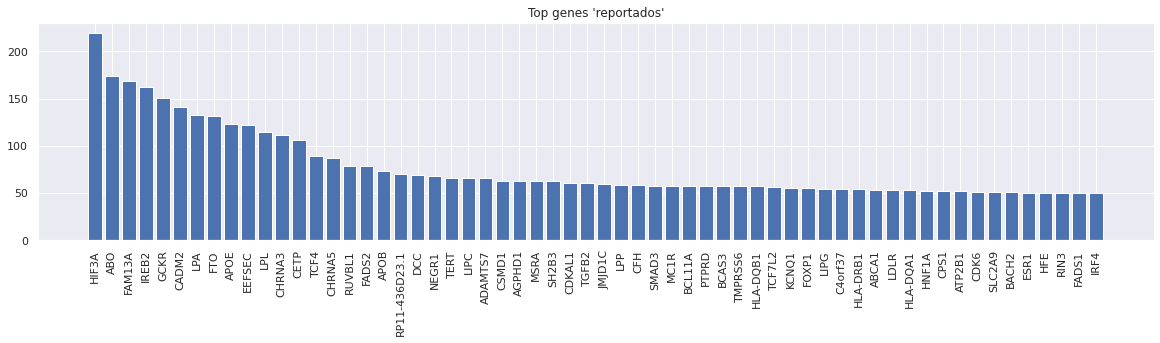

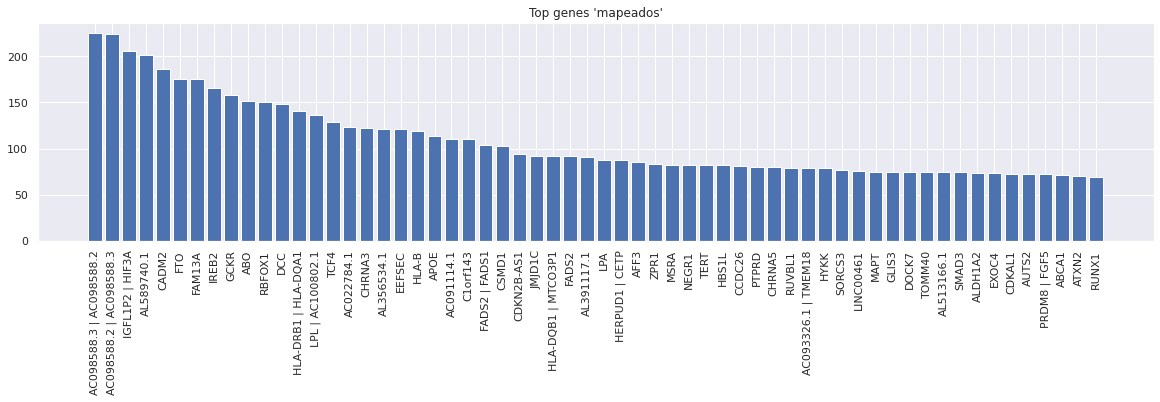

In [126]:
genes_reportados_counts = data.genes_reportados.value_counts()[:60]

plt.figure(figsize = (20,4))
plt.bar(genes_reportados_counts.index, genes_reportados_counts.values)
plt.xticks(rotation = 90)
plt.title("Top genes 'reportados'")
plt.show()

genes_mapeados_counts = data.genes_mapeados.value_counts()[:60]

plt.figure(figsize = (20,4))
plt.bar(genes_mapeados_counts.index, genes_mapeados_counts.values)
plt.xticks(rotation = 90)
plt.title("Top genes 'mapeados'")
plt.show()

## Solapamiento de fenotipos a nivel de mutaciones

In [156]:
def fenos_unicos(df):
    return df.fenotipo.unique()

fenos_por_alelo = data.groupby("alelo_riesgo").progress_apply(fenos_unicos).to_frame().rename(columns={0: "fenotipos"})

100%|██████████| 93388/93388 [00:18<00:00, 4919.82it/s]


In [159]:
fenos_por_alelo["conteo_fenotipos"] = fenos_por_alelo.fenotipos.map(len)
fenos_por_alelo = fenos_por_alelo.sort_values(by="conteo_fenotipos", ascending=False)
fenos_por_alelo.head(20)

,fenotipos,conteo_fenotipos
alelo_riesgo,,
rs1260326-T,"[Chronic kidney disease, Lipoprotein-associated phospholipase A2 activity and mass, Two-hour glucose challenge, Cardiovascular disease risk factors, Liver enzyme levels (gamma-glutamyl transferase), Platelet count, Hypertriglyceridemia, Coffee consumption (cups per day), Glomerular filtration rate in non diabetics (creatinine), Glomerular filtration rate (creatinine), Lipid traits, Blood metab...",36
rs1260326-C,"[Triglycerides, Hematological and biochemical traits, Non-albumin protein levels, Lymphocyte counts, Neutrophil count, Myeloid white cell count, White blood cell count, Resting heart rate, Hematocrit, Metabolite levels (small molecules and protein measures), Platelet count, Serum alpha1-antitrypsin levels, Sum neutrophil eosinophil counts, Granulocyte count, High light scatter reticulocyte per...",27
rs429358-C,"[Cerebral amyloid deposition positivity (PET imaging), Platelet count, Red cell distribution width, Age-related cognitive decline (memory) (slope of z-scores), Hyperopia, Alzheimer's disease (onset between ages 58 and 79), Alzheimer's disease (onset at age over 80), Alzheimer's disease, Alzheimer’s disease and/or vascular dementia (clinical subgroup VaD+), Alzheimer’s disease (clinical subgrou...",27
rs3184504-C,"[Beta-2 microglubulin plasma levels, Colorectal or endometrial cancer, Myeloid white cell count, Neutrophil count, Diastolic blood pressure, Systolic blood pressure, Lymphocyte counts, Red blood cell count, Plateletcrit, Cancer, Hematocrit, Sum neutrophil eosinophil counts, Granulocyte count, Hemoglobin concentration, White blood cell count, Sum basophil neutrophil counts, Reticulocyte count, ...",25
rs13107325-T,"[Blood pressure, Hypertension, NT-proBNP levels in acute coronary syndrome, Childhood body mass index, Schizophrenia, Intelligence (MTAG), Mean arterial pressure, HDL cholesterol levels, Male-pattern baldness, Risk-taking tendency (4-domain principal component model), Nucleus accumbens volume, Intelligence, Metabolic syndrome, Alcohol consumption, Educational attainment (years of education), M...",25
rs7412-T,"[Immature fraction of reticulocytes, Lipoprotein-associated phospholipase A2 activity change in response to darapladib treatment in cardiovascular disease, Lipoprotein phospholipase A2 activity in cardiovascular disease, Lipoprotein(a) levels adjusted for apolipoprotein(a) isoforms, Lipoprotein (a) levels, Metabolite levels (lipoprotein measures), High light scatter reticulocyte count, High li...",22
rs780094-T,"[Uric acid levels, Calcium levels, Urate levels, Metabolic traits, Plasma omega-3 polyunsaturated fatty acid levels (docosapentaenoic acid), Fasting blood insulin (BMI interaction), Fasting blood glucose (BMI interaction), Fasting blood insulin, Fasting blood glucose, Height, Alcohol consumption (drinks per week), Nonalcoholic fatty liver disease, Hypertriglyceridemia, Renal underexcretion gou...",21
rs79105258-?,"[Glomerular filtration rate, Creatinine levels, Serum uric acid levels, Mean arterial pressure, Diastolic blood pressure, High density lipoprotein cholesterol levels, Low density lipoprotein cholesterol levels, Pulse pressure, Gamma glutamyl transferase levels, Aspartate aminotransferase levels, Blood sugar levels, Alanine transaminase levels, Activated partial thromboplastin time, Mean corpus...",21
rs150813342-T,"[Myeloid white cell count, Basophil percentage of white cells, Mean platelet volume, Eosinophil counts, Plateletcrit, White blood cell count, Platelet count, Eosinophil percentage of white cells, Granulocyte count, Eosinophil percentage of granulocytes, Reticulocyte fraction of red cells, Sum neutrophil eosinophil counts, Platelet distribution width, White blood cell count (basophil), Reticulo...",18


## Distribución del effect size (OR o beta)

In [162]:
# mask_big_OR = data.OR_or_beta > 10
# data[mask_big_OR]
data.sort_values(by="OR_or_beta", ascending=False).iloc[:10]

,fenotipo,alelo_riesgo,categoria_fenotipo,genes_reportados,genes_mapeados,contexto,OR_or_beta,EFO_URI
79713,Gut microbiota (alpha diversity),rs72772823-?,Other measurement,None,RBFOX1,intron,690072.000,http://www.ebi.ac.uk/efo/EFO_0007874
79707,Gut microbiota (alpha diversity),rs12500772-?,Other measurement,None,TECRL,intron,606949.000,http://www.ebi.ac.uk/efo/EFO_0007874
79708,Gut microbiota (alpha diversity),rs12670422-?,Other measurement,None,NAT16 | MOGAT3,intergenic,482608.000,http://www.ebi.ac.uk/efo/EFO_0007874
79714,Gut microbiota (alpha diversity),rs75849231-?,Other measurement,None,BTBD9,intron,473058.000,http://www.ebi.ac.uk/efo/EFO_0007874
79712,Gut microbiota (alpha diversity),rs6443785-?,Other measurement,None,AC109131.1 | AC084211.1,regulatory_region,357191.000,http://www.ebi.ac.uk/efo/EFO_0007874
79710,Gut microbiota (alpha diversity),rs4313119-?,Other measurement,None,CASC8 | AC104370.1,intergenic,356360.000,http://www.ebi.ac.uk/efo/EFO_0007874
79709,Gut microbiota (alpha diversity),rs13335959-?,Other measurement,None,GSG1L,intron,352407.000,http://www.ebi.ac.uk/efo/EFO_0007874
79711,Gut microbiota (alpha diversity),rs471909-?,Other measurement,None,AP001994.2,intron,326588.000,http://www.ebi.ac.uk/efo/EFO_0007874
69816,Antipsychotic drug-induced QTc interval change in schizophrenia,rs1163825-A,Cardiovascular measurement,None,TEX29 | AL359649.1,intergenic,29700.000,http://www.ebi.ac.uk/efo/EFO_0008003
62085,Cerebrospinal fluid sTREM-2 levels,rs3799468-?,Other measurement,MAP7,MAP7,intron,15750.792,http://www.ebi.ac.uk/efo/EFO_0010151


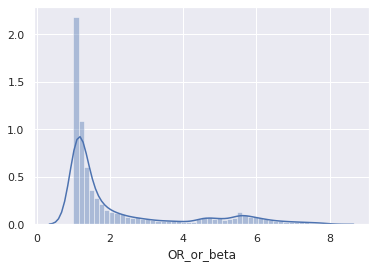

In [142]:
sns.distplot(data.OR_or_beta[(data.OR_or_beta>1) & (data.OR_or_beta<8)])

### Por fenotipo

Seleccionamos un fenotipo particular y vemos como son sus distribuciones




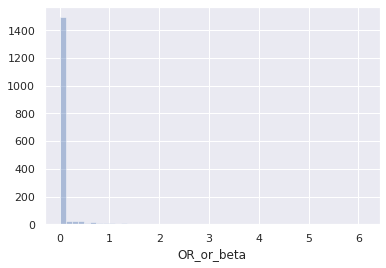

In [137]:
data_fenotipo = data[data.fenotipo == 'Body mass index']
data_fenotipo.shape

# sns.distplot(data.OR_or_beta[(data.OR_or_beta>1) & (data.OR_or_beta<8)])
# sns.distplot(np.log(data_fenotipo.OR_or_beta[data_fenotipo.OR_or_beta<1]))
# sns.distplot(np.log(data_fenotipo.OR_or_beta[(data_fenotipo.OR_or_beta>=0) & (data_fenotipo.OR_or_beta<8)]), kde = False)
sns.distplot(data_fenotipo.OR_or_beta, kde = False)